In [4]:
import matplotlib.pyplot as plt
import sys
sys.path.append("/data/home/guntherxing/dev/spdk/exp/plot")
from utils import *
import pandas as pd
import shutil
import os
import itertools

In [10]:
res_dir = "ftl_result_0805"
result_target = f"/data/home/guntherxing/{res_dir}/"
# algos = ["single_group", "sepbit", "sepgc", "mida"]
# dist = ["zipf:0.8"]
# cc = ["greedy", "cb"]
result_files = []

for subdir in os.listdir(result_target):
    sub_result_target = os.path.join(result_target, subdir)
    result_files.extend([os.path.join(sub_result_target, f) for f in os.listdir(sub_result_target)])

print(len(result_files))
print("\n".join(result_files))

IO_ITEMS = ["USER", "COMPACTION", "BASE_MD", "NVC_MD", "L2P"]

2
/data/home/guntherxing/ftl_result_0805/sepbit_greedy_zipf:0.8/32k_rand_op20.log
/data/home/guntherxing/ftl_result_0805/sepbit_cb_zipf:0.8/32k_rand_op20.log


In [11]:
def plot_io(result_file, metric, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    read_metric_dict = {}
    write_metric_dict = {}
    for item in IO_ITEMS:
        stat = extract_stat_io(result_file, item)
        read_metric_dict[item] = stat[f"read_{metric}"]
        write_metric_dict[item] = stat[f"write_{metric}"]

    read_metric_df = pd.DataFrame(read_metric_dict)
    write_metric_df = pd.DataFrame(write_metric_dict)
    read_metric_df.to_csv(os.path.join(save_dir, f"read_{metric}.csv"))
    read_metric_df = read_metric_df[int(0.1*read_metric_df.shape[0]):int(0.9*read_metric_df.shape[0])]
    plt.clf()
    plt.xlabel("Time (s)")
    if metric == "bw":
        plt.ylabel("Bandwidth (MB/s)")
    else:
        plt.ylabel("IOPS")
    read_metric_df.plot()
    plt.savefig(os.path.join(save_dir, f"read_{metric}.pdf"))
    write_metric_df.to_csv(os.path.join(save_dir, f"write_{metric}.csv"))
    write_metric_df = write_metric_df[int(0.1*write_metric_df.shape[0]):int(0.9*write_metric_df.shape[0])]
    plt.clf()
    plt.xlabel("Time (s)")
    if metric == "bw":
        plt.ylabel("Bandwidth (MB/s)")
    else:
        plt.ylabel("IOPS")
    write_metric_df.plot()
    plt.savefig(os.path.join(save_dir, f"write_{metric}.pdf"))
    

In [12]:
def plot_stat_waf(result_file, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    stat = extract_stat_waf(result_file)
    stat_df = pd.DataFrame(stat)
    stat_df.to_csv(os.path.join(save_dir, "stat_waf.csv"))
    stat_df = stat_df[int(0.1*stat_df.shape[0]):int(0.9*stat_df.shape[0])]
    plt.clf()
    stat_df.plot()
    plt.xlabel("Time (s)")
    plt.ylabel("WAF")
    plt.savefig(os.path.join(save_dir, "stat_waf.pdf"))

In [13]:
def plot_overall_waf(result_file, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    waf, final_waf = extract_overall_waf(result_file)
    stat_df = pd.DataFrame(waf)
    stat_df.to_csv(os.path.join(save_dir, "overall_waf.csv"))
    stat_df = stat_df[int(0.1*stat_df.shape[0]):int(0.9*stat_df.shape[0])]
    plt.clf()
    plt.xlabel("Time (s)")
    plt.ylabel("WAF")
    stat_df.plot()
    plt.savefig(os.path.join(save_dir, "overall_waf.pdf"))
    return waf, final_waf

     algo  c_algo      dist   bs    wr    op   IOPS  BW(MB/S)  latency  \
0  sepbit  greedy  zipf:0.8  32k  rand  op20  21700     712.0  5892.97   
1  sepbit      cb  zipf:0.8  32k  rand  op20  28500     935.0  4485.26   

   final_waf  
0     3.4902  
1     2.8174  


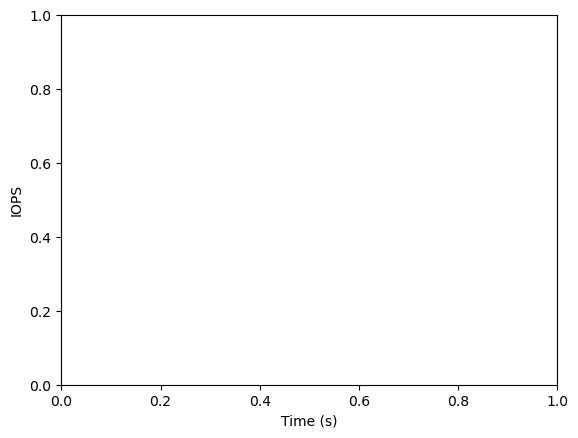

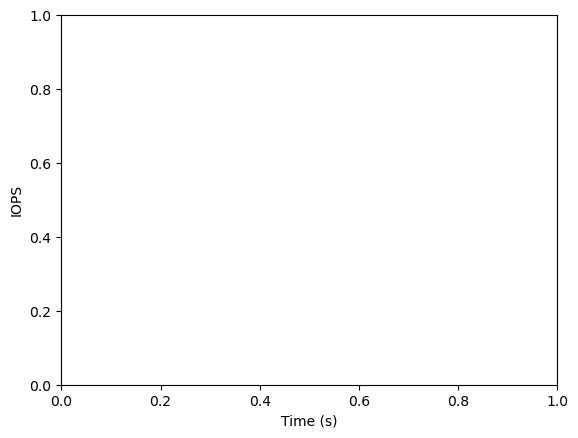

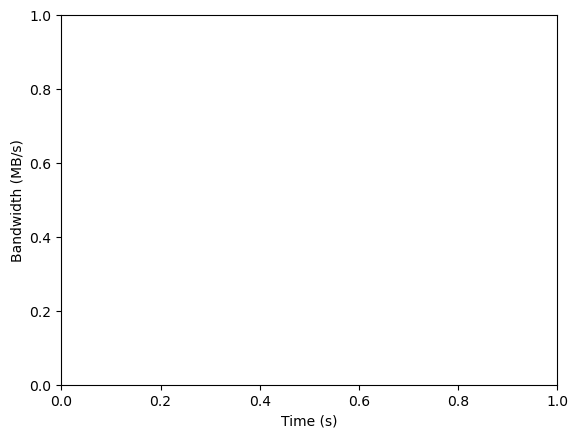

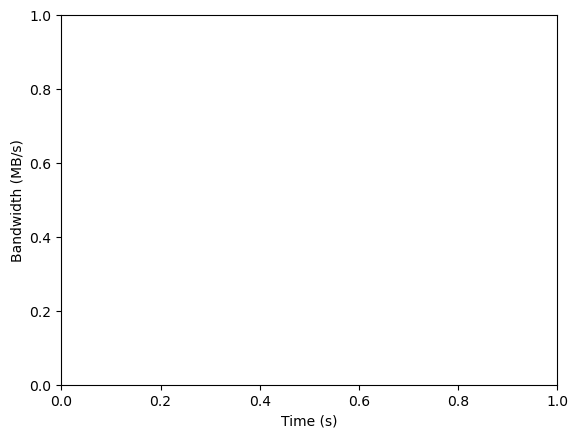

<Figure size 640x480 with 0 Axes>

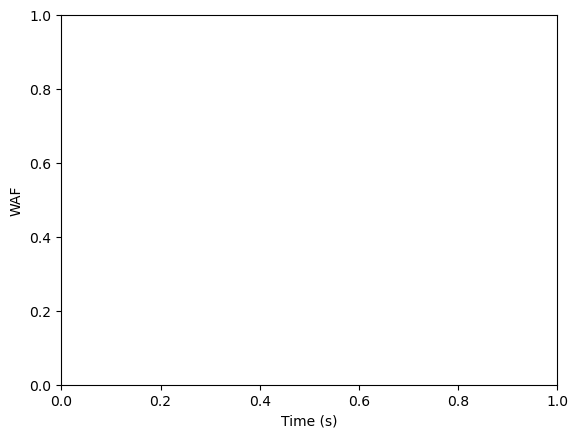

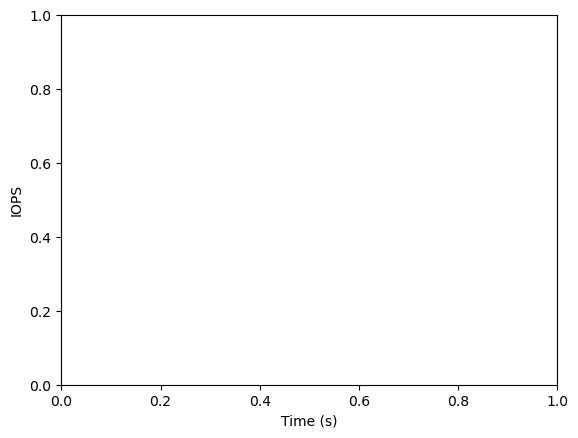

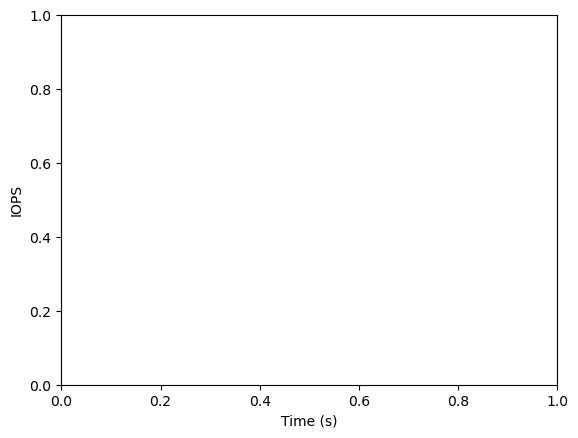

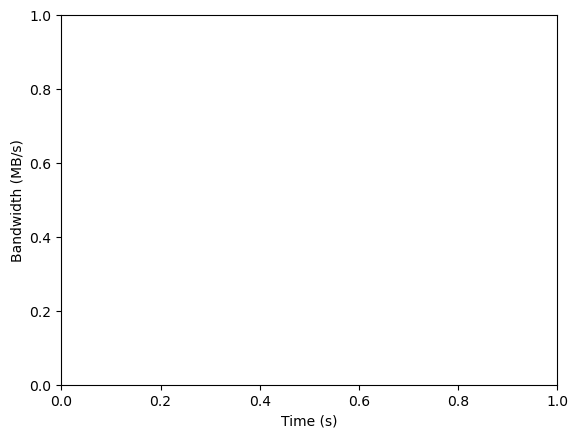

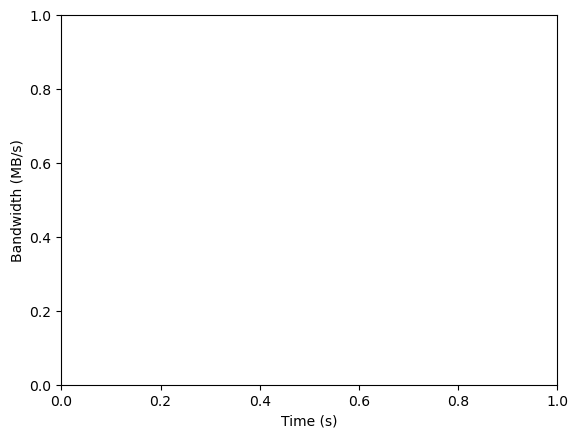

<Figure size 640x480 with 0 Axes>

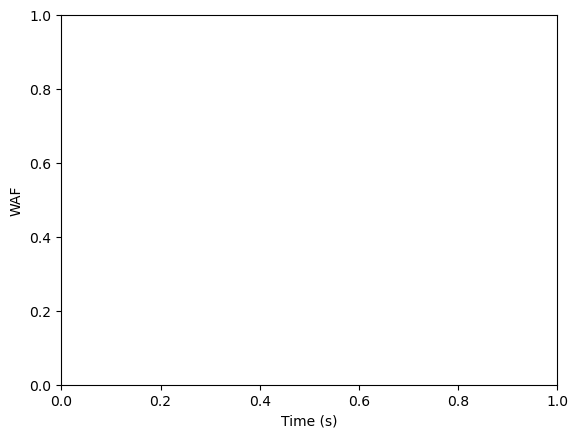

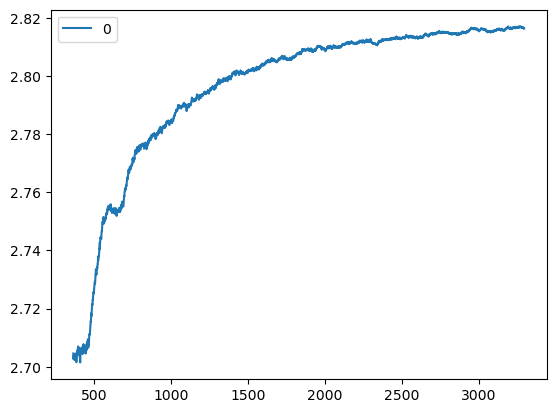

In [14]:
result_dics = []
for result_f in result_files:
    try:
        core_result_f = dump_core_log(result_f, section=3)
        algo, f = result_f.split(os.sep)[-2:]
        plot_dir = f"/data/home/guntherxing/dev/spdk/exp/plot/{res_dir}"
        if not os.path.exists(plot_dir):
            os.mkdir(plot_dir)
        save_dir = os.path.join(plot_dir, os.sep.join([algo, f]))
        for metric in ["IOPS", "bw"]:
            plot_io(core_result_f, metric, save_dir)
        plot_stat_waf(core_result_f, save_dir)
        _, final_waf = plot_overall_waf(core_result_f, save_dir)
        iops, bw, latency = extract_fio(result_f)
        c_algo, dist = algo.split("_")[-2:]
        algo = "_".join(algo.split("_")[:-2])
        bs, wr, op = f.split(".")[0].split("_")
        result_dics.append({
            "algo": algo,
            "c_algo": c_algo,
            "dist": dist,
            "bs": bs,
            "wr": wr,
            "op": op,
            "IOPS": iops,
            "BW(MB/S)": bw,
            "latency": latency,
            "final_waf": final_waf,
        })
    except Exception as e:
        print(f"Error: {e}")
    finally:
        os.remove(core_result_f)
result_df = pd.DataFrame(result_dics)
print(result_df)
result_df.to_csv(os.path.join("/data/home/guntherxing/dev/spdk/exp/result", f"{res_dir}.csv"), sep="\t")